In [1]:
%autosave 30

Autosaving every 30 seconds


# Basics
* FaceNet is a face recognition system that was described by Florian Schroff, et al. at Google in their 2015 paper titled “FaceNet: A Unified Embedding for Face Recognition and Clustering.”
* It is a system that, given a picture of a face, will extract high-quality features from the face and predict a 128 element vector representation these features, called a face embedding.

## Import liberaries

In [8]:
import os
import sys
import numpy as np
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from platform import python_version
print(f"python version: {python_version()}")

## for Image work
from PIL import Image

## for mtcnn modeling
from mtcnn.mtcnn import MTCNN
import cv2

python version: 3.7.12


In [3]:
## Get the generatl path for saved model
path_saved_model=os.environ.get('DirForSavedModel')+'/face_recognisition/'
model=load_model(path_saved_model+'facenet_keras.h5')
print(f"Input: {model.inputs}")
print(f"Output: {model.outputs}")

2021-10-21 14:40:00.010178: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Input: [<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
Output: [<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


## Import mctnn

In [4]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [5]:
images_dir = os.environ.get('DirForImages') +'/celeb/'
print(images_dir)

/Users/psaxena/Documents/images_for_testing/celeb/


In [8]:
sys.path.append(os.environ.get('DirForPoolScripts'))
from download_kaggle_data import upload_kaggle_dataset

Help on function upload_kaggle_dataset in module download_kaggle_data:

upload_kaggle_dataset(kaggle_dataset_name, base_dir_name)
    kaggle_dataset_name: name of the dataset to be downloaded, 
    base_dir_name: some directory where it suppose to be downloaded



In [9]:
base_dir = "/tmp/celebs"
dataset_name = 'dansbecker/5-celebrity-faces-dataset'
#upload_kaggle_dataset(base_dir_name=base_dir, kaggle_dataset_name=dataset_name)

In [7]:
from PIL import Image
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)

    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

2021-10-21 14:42:50.472318: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


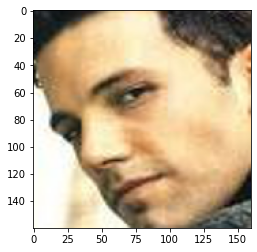

In [9]:
base_dir = os.environ.get('DirForImages')+'/5-celebrity-faces-dataset/'
ben_dir  = base_dir + '/train/ben_afflek/'

# load the photo and extract the face
pixels = extract_face(ben_dir+'httpcsvkmeuaeccjpg.jpg')
plt.imshow(pixels)

In [ ]:
# specify folder to plot
#folder = '5-celebrity-faces-dataset/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
    # path
    path = folder + filename
    # get face
    face = extract_face(path)
    print(i, face.shape)
    # plot
    pyplot.subplot(2, 7, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()


In [19]:
# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in os.listdir(directory):
    # path
        path = directory + filename
        # get face
        face = extract_face(path)
        # store
        faces.append(face)
    return faces

In [20]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in os.listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not os.path.isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return np.asarray(X), np.asarray(y)

In [23]:
# load train dataset
trainX, trainy = load_dataset(base_dir+'train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset(base_dir+'/val/')
# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 19 examples for class: madonna
>loaded 17 examples for class: elton_john
>loaded 22 examples for class: mindy_kaling
>loaded 21 examples for class: jerry_seinfeld
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: madonna
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: jerry_seinfeld


In [28]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
path_saved_model=os.environ.get('DirForSavedModel')+'/face_recognisition/'
model=load_model(path_saved_model+'facenet_keras.h5')

print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
Loaded Model
(93, 128)
(25, 128)


In [29]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))


Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


Predicted: madonna (74.439)
Expected: madonna


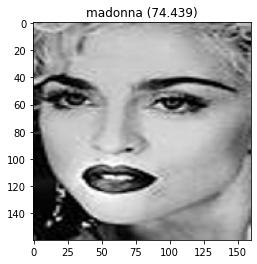

In [36]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

/Users/psaxena/Documents/images_for_testing/5-celebrity-faces-dataset//train/ben_afflek/
1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


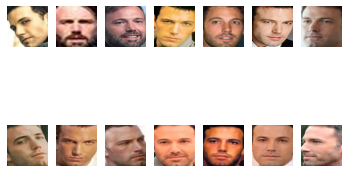

In [34]:
# specify folder to plot
base_dir = os.environ.get('DirForImages')+'/5-celebrity-faces-dataset/'
ben_dir  = base_dir + '/train/ben_afflek/'
print(ben_dir)
i = 1
# enumerate files
for filename in os.listdir(ben_dir):
    # path
    path = ben_dir + filename
    # get face
    face = extract_face(path)
    print(i, face.shape)
    # plot
    pyplot.subplot(2, 7, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()